In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import os
import re

from src.background_removal import get_mask_and_foreground, get_mask_and_foreground_w2, evaluate_pixel_mask, evaluate_masks
from src.image_dataset import ColorSpace, ImageDataset, DescriptorType

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week3')
os.chdir(BASE_PATH)
print(BASE_PATH)


DATA_DIRECTORY = '../data'

/projects/master/c1/Team5/week3


In [2]:
def validate_order(list_1: list[str], list_2: list[str]) -> bool:
    assert len(list_1) == len(list_2)

    for i in range(0, len(list_1)):
        if list_1[i].split('.')[0] != list_2[i].split('.')[0]:
            print(i, list_1[i], list_2[i])
            return False
    return True


100%|██████████| 30/30 [00:00<00:00, 37.84it/s]


29.02098935466256
28.517675334386517
28.536098333761576
27.76834860337848
33.40958134831323
33.486182775566334
33.633081359189966
38.01821626004227
32.708429717901595
43.28044021013958
44.603017365790315
43.30980487325104
33.50058129009592
27.481864139513558
38.68817887773367


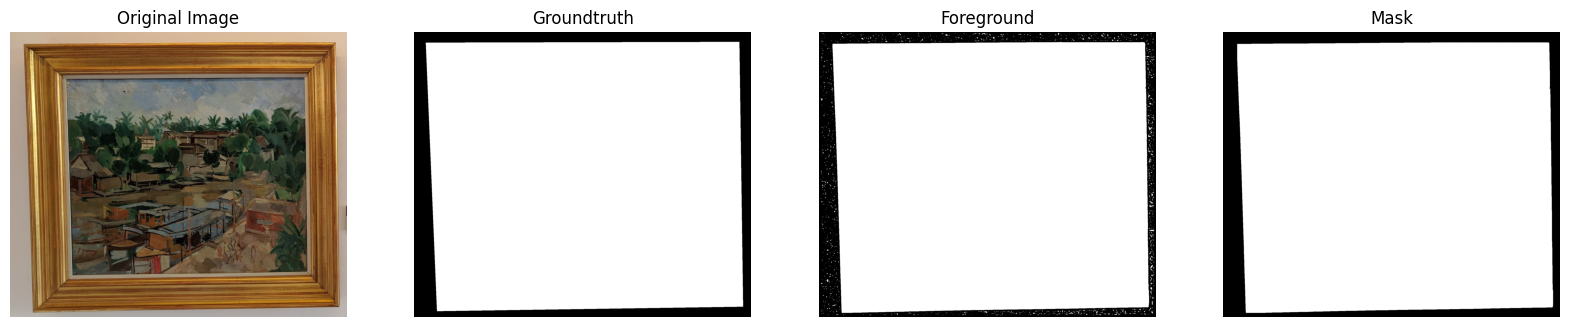

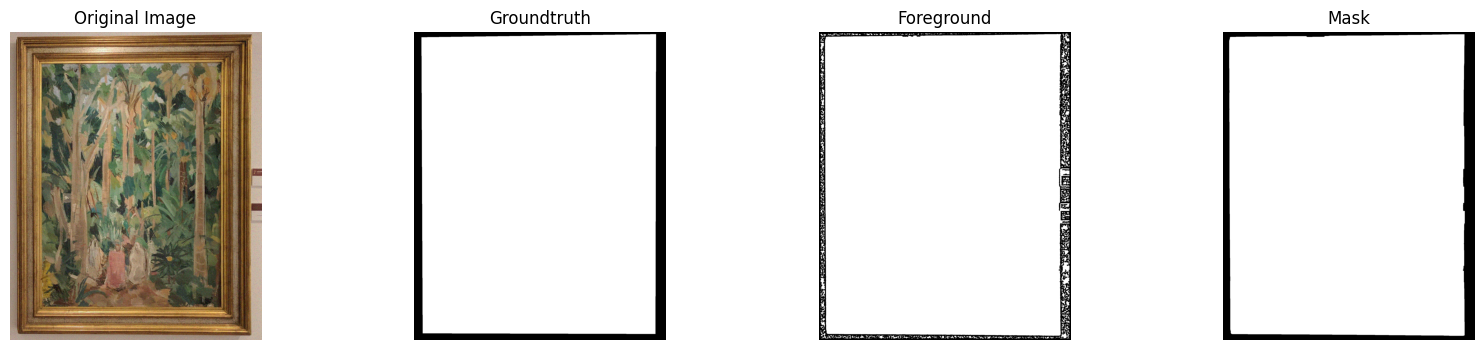

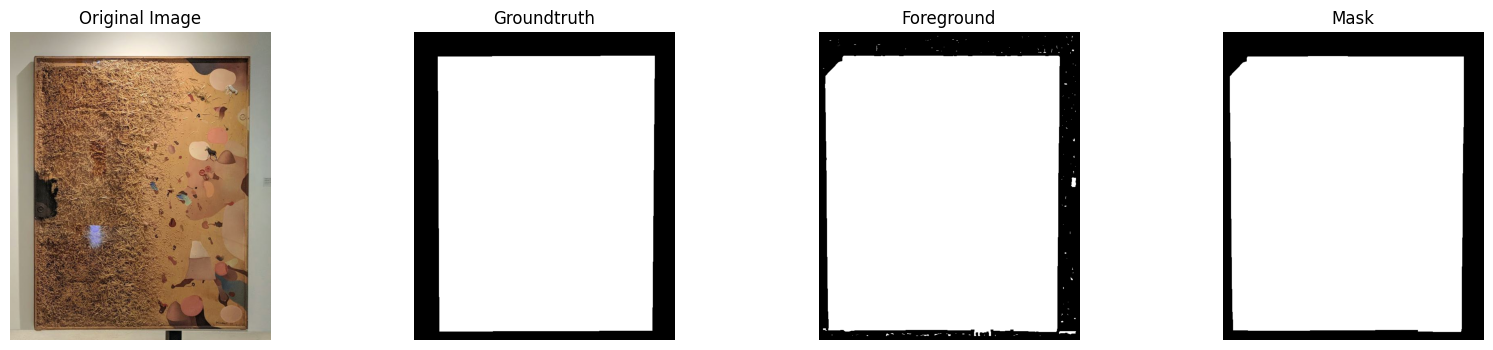

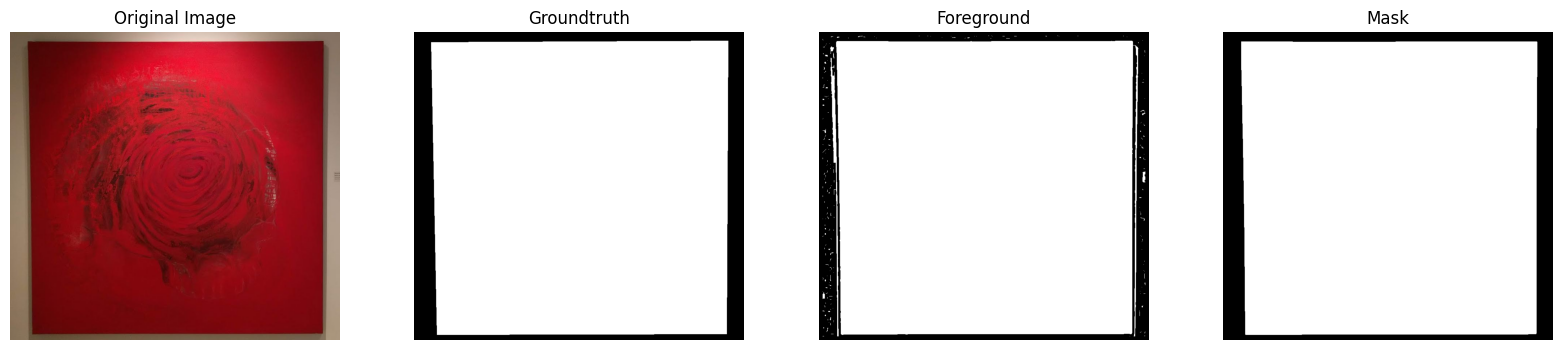

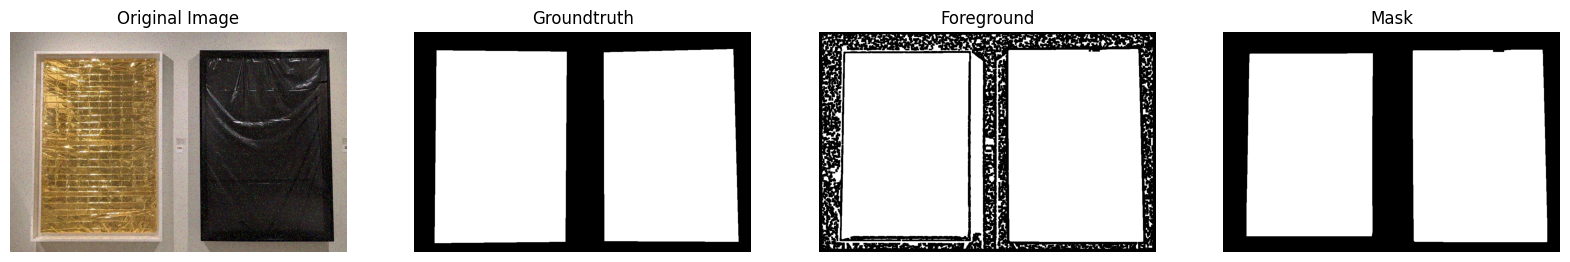

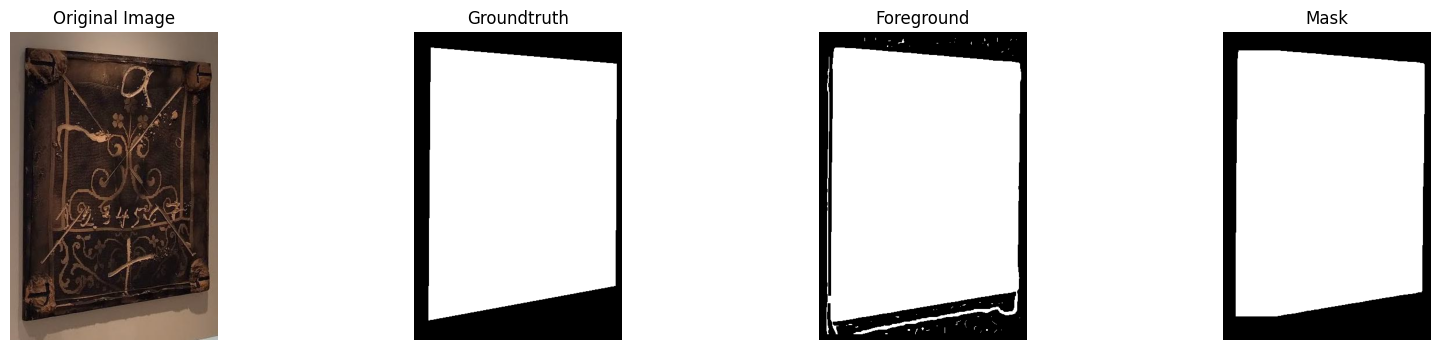

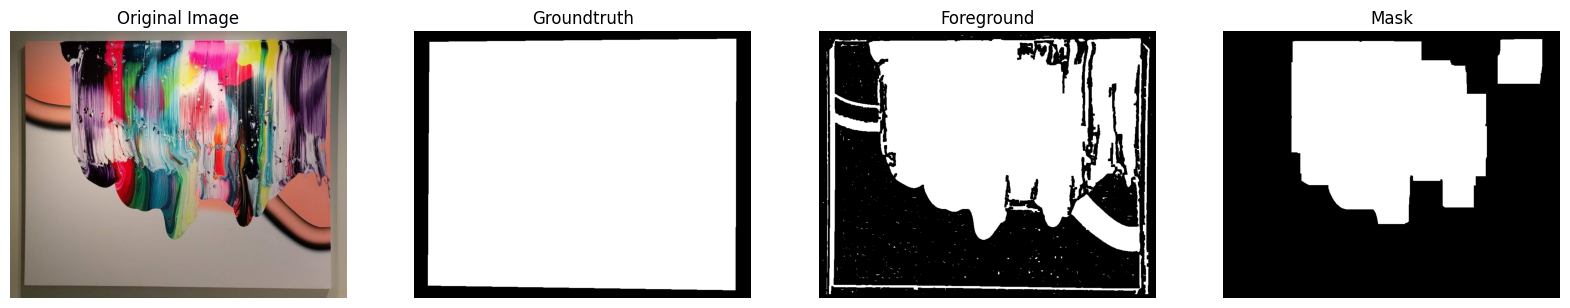

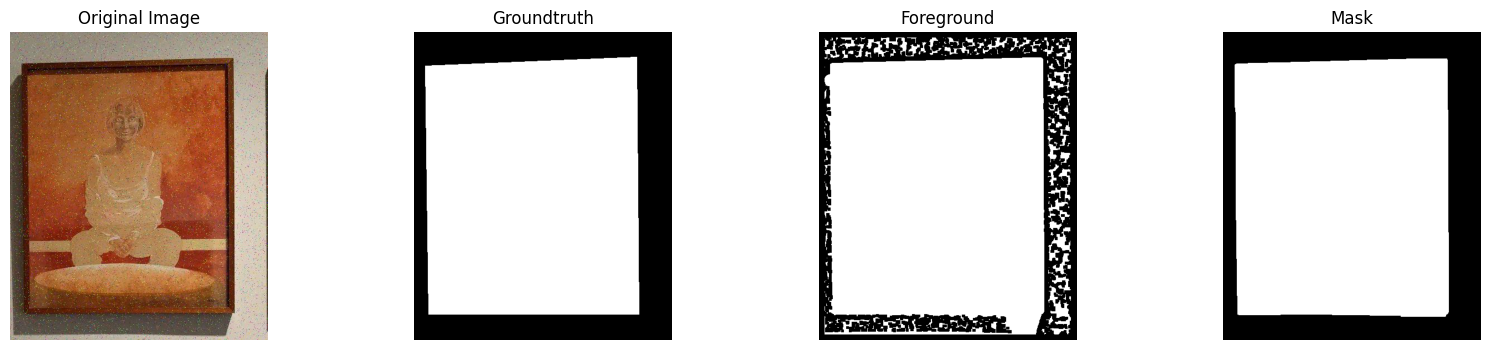

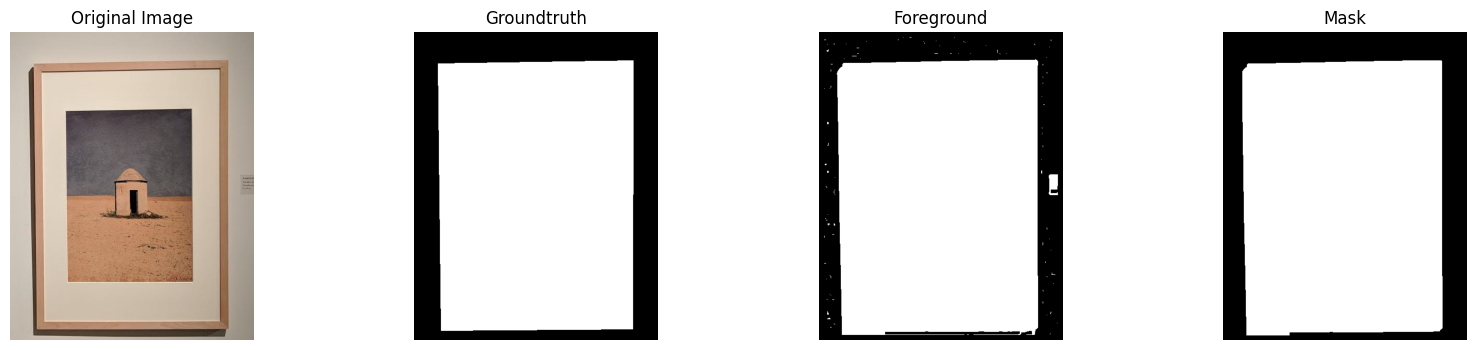

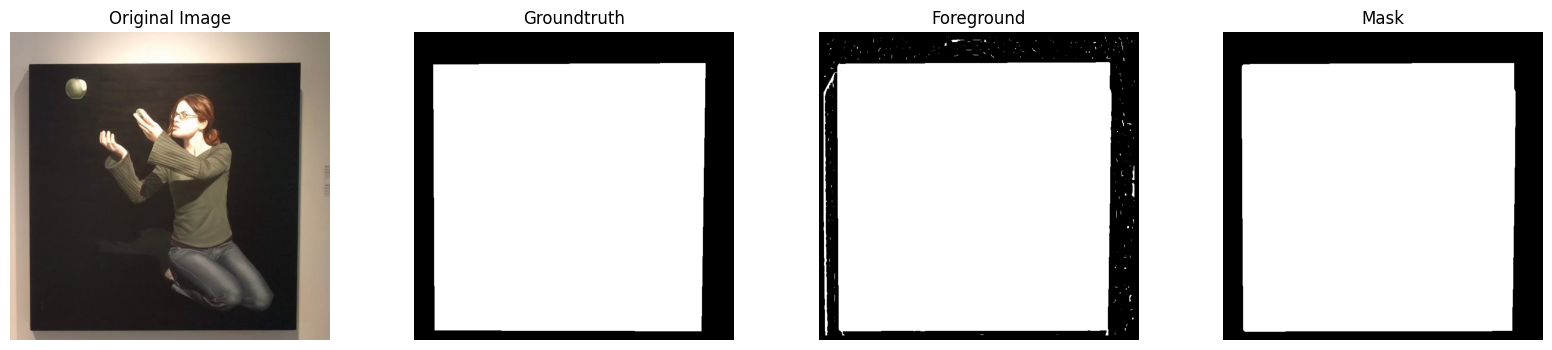

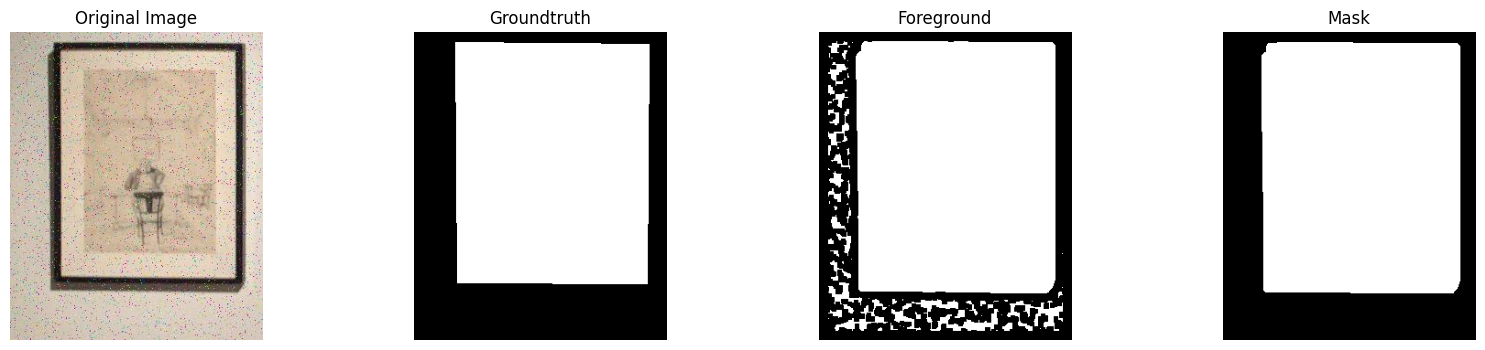

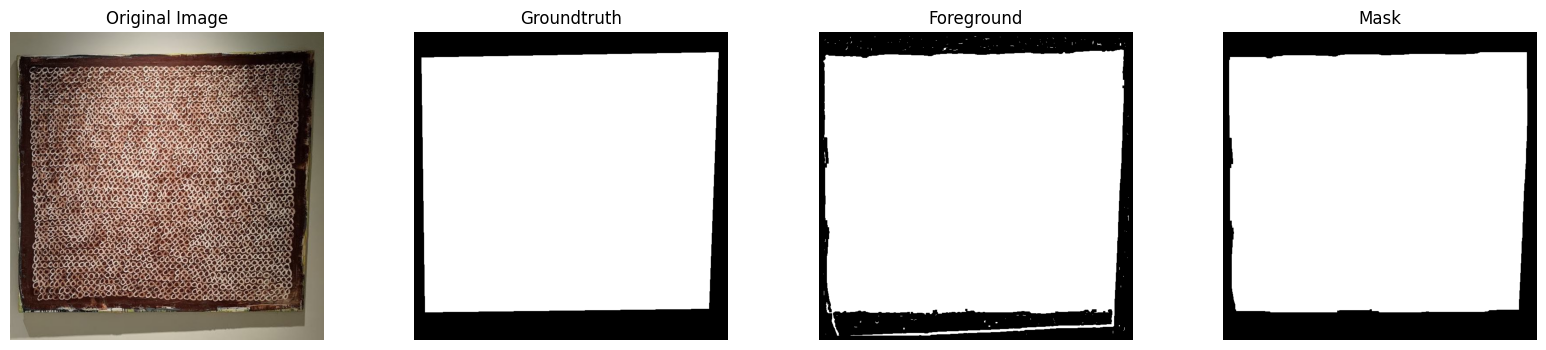

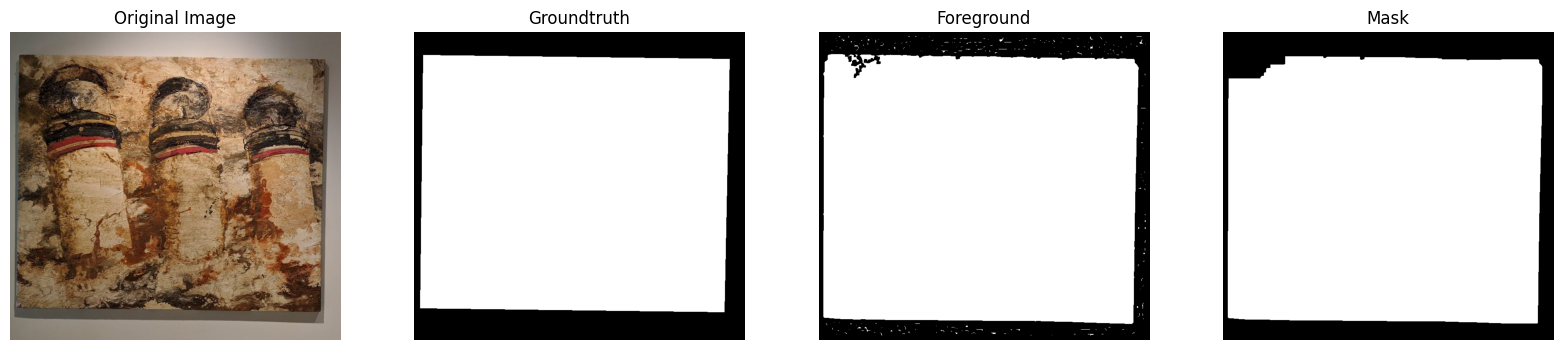

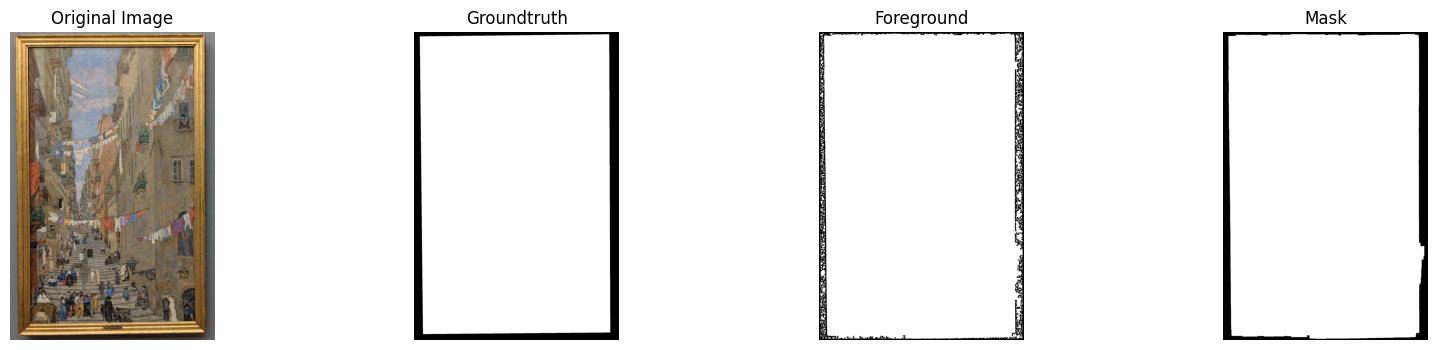

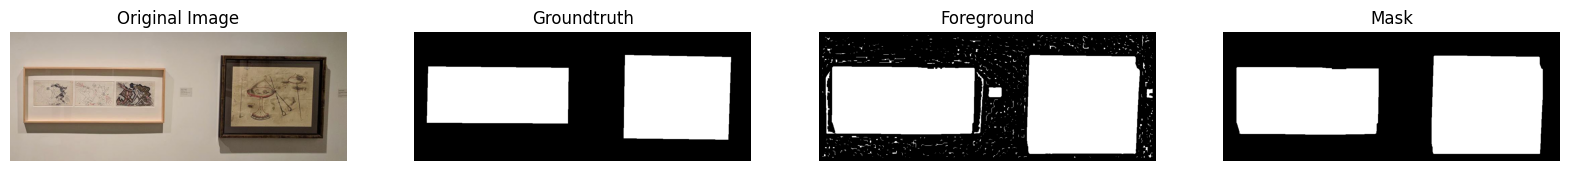

In [143]:
params = {
    'colorspace': ColorSpace.CieLab,
    'intervals': [7, 7, 7],
    'rows': 12,
    'columns': 12,
    'channels': [[0], [1], [2]]
}
BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd2_w3', DescriptorType.Block, params)

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.png')]
background_files = sorted(background_files, key=lambda x: int(re.findall(r'\d+', x)[0]))


assert validate_order(
    [image.path.split('/')[-1].split('.')[0] for image in BGDataset.images],
    [bg_file.split('.')[0] for bg_file in background_files]
    )



# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
for i in range(15, 30):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd2_w3', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Get foreground and mask
    foreground, mask = get_mask_and_foreground(image, enhancing_factor=1, th2_method='adaptative')
    plt.subplot(1, 4, 3)
    plt.imshow(foreground, cmap='gray')
    plt.title('Foreground')
    plt.axis('off')
    

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

In [73]:

bg_filenames = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.jpg')]
bg_filenames.sort()
gt_filenames = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.png')]
gt_filenames.sort()

validate_order(bg_filenames, gt_filenames)

True

In [74]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.filters import median, gaussian, laplace, prewitt, sobel
from skimage.morphology import disk

from src.background_removal import apply_filter, normalize_image



In [75]:
FOREGROUND_DIR = "data_results/foregrounds"
MASK_DIR = "data_results/masks"
dataset_name = "qsd2_w3"

if not os.path.exists(FOREGROUND_DIR):
    os.makedirs(FOREGROUND_DIR)

if not os.path.exists(MASK_DIR):
    os.makedirs(MASK_DIR)

In [76]:
import pandas as pd

for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground_w2(bg_image)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
results

Metric     Value
0  Precision  0.912636
1     Recall  0.805510
2   F1 Score  0.831088

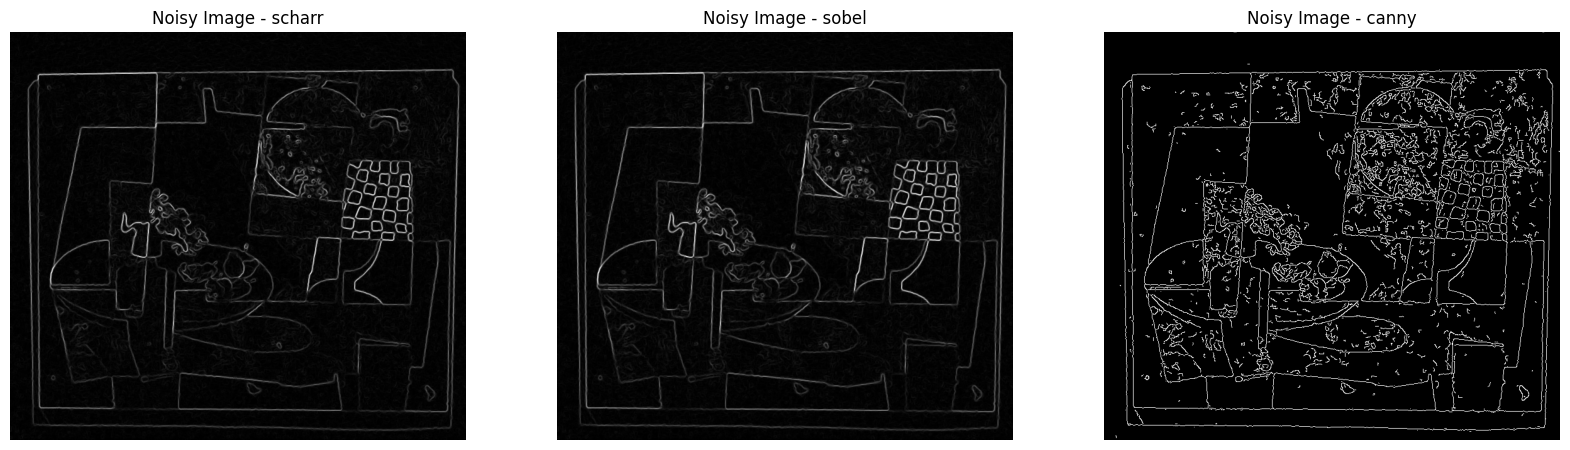

In [77]:
image_code = "00004"
noisy_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.jpg'))
og_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, 'non_augmented',f'{image_code}.jpg'))
gt_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.png'), cv2.IMREAD_GRAYSCALE)

# convert images to Gray
gray_noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
noise_reduction_filter = 'median'
gray_noisy_image = apply_filter(gray_noisy_image, noise_reduction_filter)

# # Convert images to HSV
# noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2HSV)
# og_image = cv2.cvtColor(og_image, cv2.COLOR_BGR2HSV)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
filter_name_1 = 'scharr'
axs[0].imshow(apply_filter(gray_noisy_image, filter_name_1), cmap='gray')
axs[0].set_title(f'Noisy Image - {filter_name_1}')
axs[0].axis('off')

filter_name_2 = 'sobel'
axs[1].imshow(apply_filter(gray_noisy_image, filter_name_2), cmap='gray')
axs[1].set_title(f'Noisy Image - {filter_name_2}')
axs[1].axis('off')

filter_name_3 = 'canny'
axs[2].imshow(apply_filter(gray_noisy_image, filter_name_3), cmap='gray')
axs[2].set_title(f'Noisy Image - {filter_name_3}')
axs[2].axis('off')

plt.show()
# Convert images to grayscale
# noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
# og_image = cv2.cvtColor(og_image, cv2.COLOR_BGR2GRAY)
# noisy_image = noisy_image[:,:, 2]
# og_image = og_image[:,:, 2]

29.980703458747602


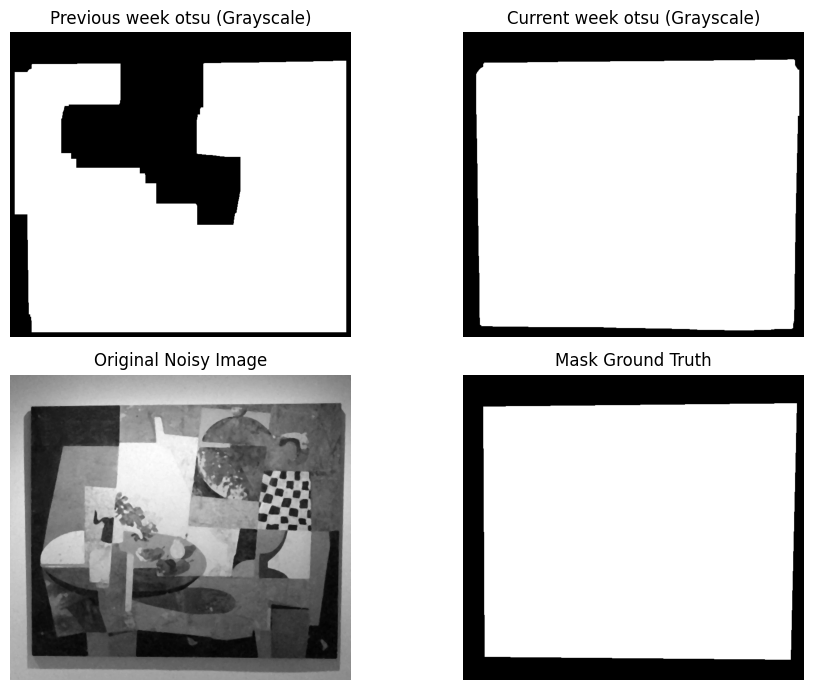

In [78]:
_, w2 = get_mask_and_foreground_w2(noisy_image)
_, w3 = get_mask_and_foreground(noisy_image)

# Plot the results
plt.figure(figsize=(10, 7))

# Original Noisy Image
plt.subplot(2, 2, 1)
plt.imshow(w2, cmap='gray')
plt.title('Previous week otsu (Grayscale)')
plt.axis('off')

# Magnitude Spectrum of Noisy Image

# Original Image
plt.subplot(2, 2, 2)
plt.imshow(w3, cmap='gray')
plt.title('Current week otsu (Grayscale)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(gray_noisy_image, cmap='gray')
plt.title('Original Noisy Image')
plt.axis('off')

# Original Image
plt.subplot(2, 2, 4)
plt.imshow(gt_image, cmap='gray')
plt.title('Mask Ground Truth')
plt.axis('off')
plt.tight_layout()

plt.show()

In [79]:

plt.close()

In [80]:
import numpy as np


def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalize the input image to the range [0, 255].

    Parameters:
    image (np.ndarray): Input image to be normalized.

    Returns:
    np.ndarray: Normalized image.
    """
    image_min = image.min()
    image_max = image.max()

    # Shift and scale normalization
    normalized_image = (image - image_min) / (image_max - image_min) * 255

    return normalized_image


# normalized_filtered_image = normalize_image(filtered_noisy_image)
# plt.imshow(normalize_image(apply_filter(noisy_image, 'median')+normalized_filtered_image*5), cmap='gray')

In [156]:

for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground(bg_image, enhancing_factor=2, th2_method='otsu',
        equalize=False, closing_size=25, opening_size=0)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
results

Metric     Value
0  Precision  0.941083
1     Recall  0.980578
2   F1 Score  0.958391

In [155]:
from tqdm import tqdm


factor = 0
equalize = False
closing_size = 5
opening_size = 35
for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground(bg_image, enhancing_factor=factor, th2_method='adaptative', equalize=equalize)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
print(results, f'factor: {factor}', f'equalize: {equalize}')
print()

      Metric     Value
0  Precision  0.959821
1     Recall  0.971008
2   F1 Score  0.961373 factor: 0 equalize: False



In [150]:
# EDGE ENHANCING + ADAPTATIVE THRESHOLDING DOS NOT WORK

# EQUALIZE AFTER THE EDGE ENHANCING DOES NOT WORK

from tqdm import tqdm

result_list_eq = []
for factor in tqdm(np.arange(0, 4, 0.2)):
    for equalize in [True]:
        for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
            bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

            fg, mask = get_mask_and_foreground(bg_image, enhancing_factor=factor, th2_method='adaptative', equalize=equalize)
            gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

            # Define paths for saving
            foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
            mask_path = os.path.join(MASK_DIR, gt_filename)

            # Save the foreground and mask
            cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
            cv2.imwrite(mask_path, mask)

        precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
        results = pd.DataFrame({
                'Metric': ['Precision', 'Recall', 'F1 Score'],
                'Value': [precision, recall, f1_score]
            })
        result_list_eq.append((factor, equalize, results))
        print(results, f'factor: {factor}', f'equalize: {equalize}')
        print()

  5%|▌         | 1/20 [00:33<10:44, 33.94s/it]

      Metric     Value
0  Precision  0.937898
1     Recall  0.978903
2   F1 Score  0.955844 factor: 0.0 equalize: True



 10%|█         | 2/20 [01:08<10:12, 34.05s/it]

      Metric     Value
0  Precision  0.929466
1     Recall  0.975225
2   F1 Score  0.948748 factor: 0.2 equalize: True



 10%|█         | 2/20 [01:25<12:51, 42.88s/it]


KeyboardInterrupt: 